In [1]:
import os
import sys
sys.path.append('..')

In [2]:
from CLTreeModules import *
from ReadWritePickleFile import *
from PruneTreeByConqueringNodes import *
from PruneTreeByMergingCentroids import *
from ClusterTree_Utility import *
from Attribute import *
from ClusterTree import *
import datetime
import math

## Skip This Cell. Jump to Test - 1

In [3]:
def getSimpleAttributes(node, othersGroup):
    # Assert node is an instance of CLNode
    assert isinstance(node, CLNode)
    
    attributes = {}
    i = 0 
    while i<len(node.dataset.attr_names):
        attr_name = node.dataset.attr_names[i]
        uniqueValues = len(np.unique(node.dataset.getInstances(attr_name)))
        
        attributes[node.dataset.attr_names[i]]= Attribute(name=attr_name,
                                                          noOfUniqueValues = uniqueValues,
                                                          maxVal=node.dataset.max_values[i+1],
                                                          minVal = node.dataset.min_values[i+1])


        i+=1

    for key in attributes.keys():
        if attributes[key].type == 'Calculated' and re.findall("_others$", attributes[key].name)\
                and attributes[key].originalAttribute in othersGroup:
            attributes[key].setOriginalAttributeVal(othersGroup[attributes[key].originalAttribute])
        elif attributes[key].type == 'Calculated' and re.findall("_weekend$", attributes[key].name):
            attributes[key].setOriginalAttributeVal(['friday', 'saturday', 'fri', 'sat'])
        elif attributes[key].type == 'Calculated' and re.findall("_midweek$", attributes[key].name):
            attributes[key].setOriginalAttributeVal(['tuesday','wednesday', 'thursday','tue', 'wed', 'thu'])
        elif attributes[key].type == 'Calculated' and re.findall("_earlyweek$", attributes[key].name):
            attributes[key].setOriginalAttributeVal(['sunday', 'monday', 'sun', 'mon'])
        
            
    return attributes

def buildSimpleTree(CLNode, node, attributes):
    #Check if ClusterTreeNode is None and CLNode is Root
    curNode = ClusterTreeNode()
    
    if CLNode.includedInCluster:
        curNode.setParent(node)
        if CLNode.parent is None:
            curNode.setInheriatedFraction(1.0)
            if CLNode.clusterId is not None:
                curNode.setClusterId(CLNode.clusterId.strip().lower())
            else:
                curNode.setClusterId('DEFAULT')
        else:
            curNode.setInheriatedFraction(CLNode.dataset.length()/CLNode.parent.dataset.length())
            curNode.setClusterId(CLNode.clusterId.strip().lower())
        
    
    else:
        
        attribute = CLNode.attribute
        cutValue = CLNode.cutValue

        if attributes[attribute].type == 'Categorical' or attributes[attribute].type == 'Calculated':
            curNode.setAttribute(attribute=attributes[attribute].originalAttribute,
                                 attributeType=attributes[attribute].type)
            curNode.setValue(attributes[attribute].originalAttributeVal)

        else:
            curNode.setAttribute(attribute=attributes[attribute].originalAttribute, attributeType=attributes[attribute].type)
            curNode.setValue(cutValue)
            
        if CLNode.depth>0:
            curNode.setInheriatedFraction(CLNode.dataset.length()/CLNode.parent.dataset.length())
        else:
            curNode.setInheriatedFraction(0.)
        curNode.setParent(node)
        CLNodeChildren = CLNode.getChildNodes()
        left = buildSimpleTree(CLNodeChildren[0], curNode, attributes)
        curNode.setLeft(left)
        right = buildSimpleTree(CLNodeChildren[1], curNode, attributes)
        curNode.setRight(right)
        
    return curNode


def __validateMinMaxCriteria(min_y, min_split_fraction, data_length,
                             fractionOfTotalData, mergingCentroidsVsconqueringNodes, testMode):
    if testMode:
        return min_y, min_split_fraction
    
    assert fractionOfTotalData <=1.0 and fractionOfTotalData > 0.,\
        logger.error("The value of 'fractionOfTotalData' should be greater than 0 and less than or equal to 1.")
    if mergingCentroidsVsconqueringNodes:
        initial_override_min_y = 1000.0
    else:
        initial_override_min_y = 750.0
    
    if data_length > 5000.0:
        if fractionOfTotalData < 1.0:
            initial_override_min_y = math.floor(initial_override_min_y * fractionOfTotalData)
            
    else:
        if fractionOfTotalData < 1.0:
            initial_override_min_y = math.floor(initial_override_min_y * fractionOfTotalData * (data_length/5000))
    
    min_y = max(initial_override_min_y, min_y)
    
    if not mergingCentroidsVsconqueringNodes:
        min_split_fraction = min(min_split_fraction, (100/data_length))
    else:
        min_split_fraction = min(min_split_fraction, (min_y/data_length))
    
    logger.info("The min-split fraction has been set to {}".format(min_split_fraction))
    logger.info("The min_y (The minimum number of member required for a cluster) has been set to {}".format(min_y))
    
    return min_y, min_split_fraction


def __combine(monthsToTree, keys, attribute, defaultValues, curVer):
    if len(keys) == 1:
        key = keys[0]
        return monthsToTree[key]
        
    curNode = ClusterTreeNode()
    mid = math.ceil((len(keys)-1)/2)
    keys_l = keys[:mid]
    keys_r = keys[mid:]
    subtree_l = __combine(monthsToTree,keys_l, attribute, defaultValues, curVer)
    subtree_r = __combine(monthsToTree,keys_r, attribute, defaultValues, curVer)
    cutValue = ()
    for i in keys_r:
        cutValue = cutValue + i
    curNode.setAttribute(attribute=attribute, attributeType='Calculated')
    curNode.setValue(list(cutValue))
    curNode.setLeft(subtree_l.getRoot())
    subtree_l.getRoot().setParent(curNode)
    curNode.setRight(subtree_r.getRoot())
    subtree_r.getRoot().setParent(curNode)
    clusterTree = ClusterTree(curNode, defaultValues, curVer)
    return clusterTree


def __getClusterTreeFromData(data, categoricalAttributes, mergingCentroidsVsconqueringNodes, balancedPrune,
                             min_y, min_split_fraction, conquerDataColumns, prefixString, defaultValues, prevVer):
    
    if categoricalAttributes is not None:
        othersGroup, data = getOthersGoup(data, categoricalAttributes, min_split_fraction)
    else:
        othersGroup = None

    data.reset_index(inplace=True, drop=True)

    if not mergingCentroidsVsconqueringNodes:
        if conquerDataColumns is not None:
            conquerData = pd.DataFrame(data[conquerDataColumns].copy(deep=True))
            data = data[list(set(data.columns)-set(conquerDataColumns))].copy(deep=True)
            divideData = data.copy(deep=True)
        else:
            eps = 0.00001
            divideData = data.copy(deep=True)
            conquerData = data.copy(deep=True)
            for col in conquerData.columns:
                mn = min(conquerData[col])
                mx = max(conquerData[col])
                conquerData[col] = (conquerData[col] - mn)/(mx - mn + eps)
                
    d_var = dict(data.var())
    d_cols = sorted(d_var, key=d_var.get, reverse=True)
    data = data[d_cols]


    r = DataFrameReader(data)
    data = r.read()
    min_split = np.ceil(data.length() * min_split_fraction)
    cltree = CLTree(data, min_split)
    cltree.buildTree()
    min_y = max(min_y, min_split)
    data_length = data.length()

    if mergingCentroidsVsconqueringNodes:
        result, baseVer = pruneByGridSearch_Centroid(cltree, min_y, data_length, prefixString, balancedPrune)
    else:
        gradientTolerance = 0.05
        result, baseVer = pruneByGridSearch(cltree, min_y, prefixString, gradientTolerance, conquerData, divideData)

    utc_now = datetime.datetime.now()
    deltaVer = math.ceil(float((utc_now - datetime.datetime(1970, 1, 1)).total_seconds()))
    deltaVer = float("." + str(deltaVer))
    
    if math.floor(prevVer) == math.floor(baseVer):
        curVer = baseVer + deltaVer
    else:
        curVer = baseVer
    
    attributes = getSimpleAttributes(node=cltree.root, othersGroup=othersGroup)
    simpleTreeRoot = buildSimpleTree(CLNode=cltree.root, node = None, attributes=attributes)            
    clusterTree = ClusterTree(simpleTreeRoot, defaultValues, curVer)
    return clusterTree

## Test - 1

**Test of pruning on demo data with min_y = 20[soft bound, hard bound = (20 - 20*0.1)]. 
Mechanism used here, is "MergingCentroids".**

In [4]:
df = pd.read_csv('ToDemotestData.csv', delimiter=';')
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
df.columns = ['people', 'avgspend']
defaultValues = {'people': 2.0, 'avgspend': 35.0}

In [6]:
clusterTree = __getClusterTreeFromData(df, categoricalAttributes = None, mergingCentroidsVsconqueringNodes=True,
                                       balancedPrune=False, min_y=20, min_split_fraction=0.05,
                                       conquerDataColumns=None,
                                       prefixString='DEMO_DATA_', defaultValues=defaultValues, prevVer=0.0)

attributes, clusters = getAttributesAndClusters(clusterTree)
writePickleFile(path='./DEMO_DATA_ClusterTree_MC_P.pickle', data=clusterTree)

2019-11-24 19:49:57,586 - 4748465600 - INFO - read 100
2019-11-24 19:49:57,587 - 4748465600 - INFO - attribute names: [('id', <class 'float'>), ('avgspend', <class 'float'>), ('people', <class 'float'>)]
2019-11-24 19:49:57,588 - 4748465600 - INFO - This is the starting point!
2019-11-24 19:49:57,598 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 8.0
2019-11-24 19:49:57,599 - 4748465600 - INFO - At previous level(0), the cut happened on Attribute:people, Value: 8.0
2019-11-24 19:49:57,609 - 4748465600 - INFO - At this level the best cut is found on Attribute: avgspend, at: 78.0
2019-11-24 19:49:57,610 - 4748465600 - INFO - At previous level(1), the cut happened on Attribute:avgspend, Value: 78.0
2019-11-24 19:49:57,621 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 7.0
2019-11-24 19:49:57,622 - 4748465600 - INFO - At previous level(2), the cut happened on Attribute:people, Value: 7.0
2019-11-24 19:49:57,631 - 474

2019-11-24 19:49:57,772 - 4748465600 - INFO - Level: 20, Datapoints: 
Data: 3
['avgspend', 'people']
 Max :[84. 43.  3.]
 Min :[22. 42.  2.]

--------

2019-11-24 19:49:57,773 - 4748465600 - INFO - Inadequate data points to create further split on right child!
2019-11-24 19:49:57,774 - 4748465600 - INFO - Level: 20, Datapoints: 
Data: 4
['avgspend', 'people']
 Max :[81. 46.  3.]
 Min :[ 3. 44.  2.]

--------

2019-11-24 19:49:57,774 - 4748465600 - INFO - At previous level(17), the cut happened on Attribute:avgspend, Value: 46.0
2019-11-24 19:49:57,775 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 2.0
2019-11-24 19:49:57,776 - 4748465600 - INFO - At previous level(18), the cut happened on Attribute:people, Value: 2.0
2019-11-24 19:49:57,778 - 4748465600 - INFO - At this level the best cut is found on Attribute: avgspend, at: 49.0
2019-11-24 19:49:57,778 - 4748465600 - INFO - Inadequate data points to create further split on left child!
2019-11-24 19

2019-11-24 19:49:57,823 - 4748465600 - INFO - Printing MergeList: []
2019-11-24 19:49:57,823 - 4748465600 - INFO - Printing Touching Nodes: {}
2019-11-24 19:49:57,828 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 28, 25, 20, 9]),  #Clusters: 4.99, argminMetric: 0.13471577799183168
2019-11-24 19:49:57,830 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([25, 20, 46, 9]),  #Clusters: 3.99, argminMetric: 0.18414187533321125
2019-11-24 19:49:57,832 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([20, 46, 34]),  #Clusters: 3, argminMetric: 0.33253443809287114
2019-11-24 19:49:57,834 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([46, 54]),  #Clusters: 2, argminMetric: 0.9647124039227286
2019-11-24 19:49:57,836 - 4748465600 - INFO - Searching for 'min_y'. Current 'min_y' = 18.0, 'result' = 
{'intra-cluster-distance': 0.019304857592003587, 'inter-cluster-distance': 0.14330057228065124, 'purity': 0.1347158443596123, 'varPurity': 1.287925264033032, 'me

2019-11-24 19:49:57,915 - 4748465600 - INFO - Printing MergeList: []
2019-11-24 19:49:57,915 - 4748465600 - INFO - Printing Touching Nodes: {}
2019-11-24 19:49:57,919 - 4748465600 - INFO - Min_Y: 20.0, Scenario: dict_values([25, 20, 46, 9]),  #Clusters: 3.99, argminMetric: 0.18414187533321125
2019-11-24 19:49:57,921 - 4748465600 - INFO - Min_Y: 20.0, Scenario: dict_values([20, 46, 34]),  #Clusters: 3, argminMetric: 0.33253443809287114
2019-11-24 19:49:57,923 - 4748465600 - INFO - Min_Y: 20.0, Scenario: dict_values([46, 54]),  #Clusters: 2, argminMetric: 0.9647124039227286
2019-11-24 19:49:57,924 - 4748465600 - INFO - Searching for 'min_y'. Current 'min_y' = 20.0, 'result' = 
{'intra-cluster-distance': 0.02196654606006017, 'inter-cluster-distance': 0.11929136220699654, 'purity': 0.18414196680848877, 'varPurity': 1.6134520954175484, 'mean-members': 25.0, 'data-points': {'DEMO_DATA__cluster_0': 25, 'DEMO_DATA__cluster_1': 20, 'DEMO_DATA__cluster_2': 46, 'DEMO_DATA__cluster_DEFAULT': 9}, '

True

In [7]:
import matplotlib.pyplot as plt  # Not Required for Inference, but I am planning to plot few things here.
%matplotlib

Using matplotlib backend: MacOSX


In [8]:
preds = []
for i in range(len(df)):
    info = dict(df.loc[i])
    pred, _ = clusterTree.getClusterID(info) 
    preds.append(pred)
df['Predicted_Cluster'] = preds

In [9]:
df['Predicted_Cluster'].value_counts()

demo_data__cluster_1          28
demo_data__cluster_2          25
demo_data__cluster_3          20
demo_data__cluster_0          18
demo_data__cluster_default     9
Name: Predicted_Cluster, dtype: int64

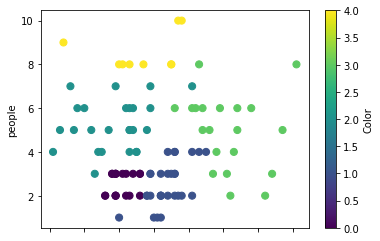

In [10]:
colorsByClusters = {'demo_data__cluster_0':0, 'demo_data__cluster_1': 1, 'demo_data__cluster_2':2,
                    'demo_data__cluster_3':3, 'demo_data__cluster_default':4}

df['Color'] = df['Predicted_Cluster'].apply(lambda x: colorsByClusters.get(x))
df.plot.scatter(x="avgspend", y ="people", c='Color', colormap='viridis', s = 50)

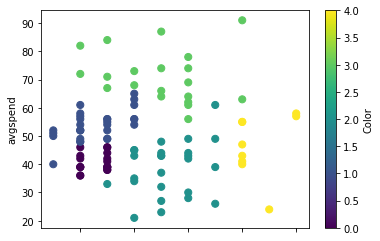

In [11]:
df.plot.scatter(x="people", y ="avgspend", c='Color', colormap='viridis', s = 50)

## Test - 2

**Test of pruning on demo data with min_y = 20[soft bound, hard bound = (20 - 20*0.1)]. 
Mechanism used here, is "MergingCentroids" and through this process we are also looking for "balanced" distribution of data points among the clusters without compromising the qulaity of the clusters.**

In [12]:
df = pd.read_csv('ToDemotestData.csv', delimiter=';')
df.drop(columns='Unnamed: 0', inplace=True)

In [13]:
df.columns = ['people', 'avgspend']
defaultValues = {'people': 2.0, 'avgspend': 35.0}

In [14]:
clusterTree = __getClusterTreeFromData(df, categoricalAttributes = None, mergingCentroidsVsconqueringNodes=True,
                                       balancedPrune=True, min_y=20, min_split_fraction=0.05,
                                       conquerDataColumns=None,
                                       prefixString='DEMO_DATA_', defaultValues=defaultValues, prevVer=0.0)

attributes, clusters = getAttributesAndClusters(clusterTree)
writePickleFile(path='./DEMO_DATA_ClusterTree_MC_BlP.pickle', data=clusterTree)

2019-11-24 19:49:58,666 - 4748465600 - INFO - read 100
2019-11-24 19:49:58,667 - 4748465600 - INFO - attribute names: [('id', <class 'float'>), ('avgspend', <class 'float'>), ('people', <class 'float'>)]
2019-11-24 19:49:58,668 - 4748465600 - INFO - This is the starting point!
2019-11-24 19:49:58,682 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 8.0
2019-11-24 19:49:58,683 - 4748465600 - INFO - At previous level(0), the cut happened on Attribute:people, Value: 8.0
2019-11-24 19:49:58,695 - 4748465600 - INFO - At this level the best cut is found on Attribute: avgspend, at: 78.0
2019-11-24 19:49:58,696 - 4748465600 - INFO - At previous level(1), the cut happened on Attribute:avgspend, Value: 78.0
2019-11-24 19:49:58,709 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 7.0
2019-11-24 19:49:58,710 - 4748465600 - INFO - At previous level(2), the cut happened on Attribute:people, Value: 7.0
2019-11-24 19:49:58,722 - 474

2019-11-24 19:49:58,891 - 4748465600 - INFO - Level: 20, Datapoints: 
Data: 3
['avgspend', 'people']
 Max :[84. 43.  3.]
 Min :[22. 42.  2.]

--------

2019-11-24 19:49:58,892 - 4748465600 - INFO - Inadequate data points to create further split on right child!
2019-11-24 19:49:58,892 - 4748465600 - INFO - Level: 20, Datapoints: 
Data: 4
['avgspend', 'people']
 Max :[81. 46.  3.]
 Min :[ 3. 44.  2.]

--------

2019-11-24 19:49:58,894 - 4748465600 - INFO - At previous level(17), the cut happened on Attribute:avgspend, Value: 46.0
2019-11-24 19:49:58,896 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 2.0
2019-11-24 19:49:58,897 - 4748465600 - INFO - At previous level(18), the cut happened on Attribute:people, Value: 2.0
2019-11-24 19:49:58,900 - 4748465600 - INFO - At this level the best cut is found on Attribute: avgspend, at: 49.0
2019-11-24 19:49:58,900 - 4748465600 - INFO - Inadequate data points to create further split on left child!
2019-11-24 19

2019-11-24 19:49:58,960 - 4748465600 - INFO - Printing MergeList: []
2019-11-24 19:49:58,961 - 4748465600 - INFO - Printing Touching Nodes: {}
2019-11-24 19:49:58,965 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 28, 25, 20, 9]),  #Clusters: 4.99, argminMetric: 1.287925103484724
2019-11-24 19:49:58,968 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([25, 20, 46, 9]),  #Clusters: 3.99, argminMetric: 1.6134517119961
2019-11-24 19:49:58,971 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([20, 46, 34]),  #Clusters: 3, argminMetric: 2.194262628222883
2019-11-24 19:49:58,973 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([46, 54]),  #Clusters: 2, argminMetric: 3.8090330552702043
2019-11-24 19:49:58,975 - 4748465600 - INFO - Searching for 'min_y'. Current 'min_y' = 18.0, 'result' = 
{'intra-cluster-distance': 0.019304857592003587, 'inter-cluster-distance': 0.14330057228065124, 'purity': 0.1347158443596123, 'varPurity': 1.287925264033032, 'mean-membe

2019-11-24 19:49:59,080 - 4748465600 - INFO - Printing MergeList: []
2019-11-24 19:49:59,080 - 4748465600 - INFO - Printing Touching Nodes: {}
2019-11-24 19:49:59,088 - 4748465600 - INFO - Min_Y: 20.0, Scenario: dict_values([25, 20, 46, 9]),  #Clusters: 3.99, argminMetric: 1.6134517119961
2019-11-24 19:49:59,093 - 4748465600 - INFO - Min_Y: 20.0, Scenario: dict_values([20, 46, 34]),  #Clusters: 3, argminMetric: 2.194262628222883
2019-11-24 19:49:59,095 - 4748465600 - INFO - Min_Y: 20.0, Scenario: dict_values([46, 54]),  #Clusters: 2, argminMetric: 3.8090330552702043
2019-11-24 19:49:59,097 - 4748465600 - INFO - Searching for 'min_y'. Current 'min_y' = 20.0, 'result' = 
{'intra-cluster-distance': 0.02196654606006017, 'inter-cluster-distance': 0.11929136220699654, 'purity': 0.18414196680848877, 'varPurity': 1.6134520954175484, 'mean-members': 25.0, 'data-points': {'DEMO_DATA__cluster_0': 25, 'DEMO_DATA__cluster_1': 20, 'DEMO_DATA__cluster_2': 46, 'DEMO_DATA__cluster_DEFAULT': 9}, 'argmin

True

In [15]:
preds = []
for i in range(len(df)):
    info = dict(df.loc[i])
    pred, _ = clusterTree.getClusterID(info) 
    preds.append(pred)
df['Predicted_Cluster'] = preds

In [16]:
df['Predicted_Cluster'].value_counts()

demo_data__cluster_1          28
demo_data__cluster_2          25
demo_data__cluster_3          20
demo_data__cluster_0          18
demo_data__cluster_default     9
Name: Predicted_Cluster, dtype: int64

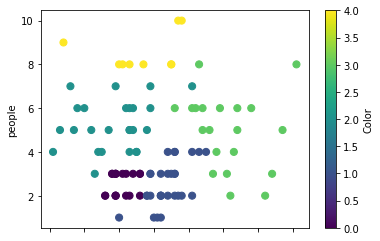

In [17]:
colorsByClusters = {'demo_data__cluster_0':0, 'demo_data__cluster_1': 1, 'demo_data__cluster_2':2,
                    'demo_data__cluster_3':3, 'demo_data__cluster_default':4}

df['Color'] = df['Predicted_Cluster'].apply(lambda x: colorsByClusters.get(x))
df.plot.scatter(x="avgspend", y ="people", c='Color', colormap='viridis', s = 50)

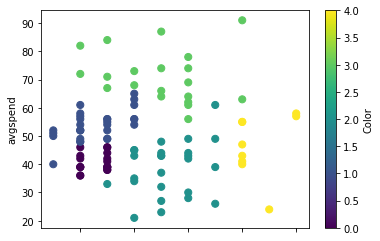

In [18]:
df.plot.scatter(x="people", y ="avgspend", c='Color', colormap='viridis', s = 50)

## Test - 3

**Test of pruning on demo data with min_y = 20[soft bound, hard bound = (20 - 20*0.1)]. 
Mechanism used here, is "ConqueringNodes" with reusing the original data.**

In [19]:
df = pd.read_csv('ToDemotestData.csv', delimiter=';')
df.drop(columns='Unnamed: 0', inplace=True)

In [20]:
df.columns = ['people', 'avgspend']
defaultValues = {'people': 2.0, 'avgspend': 35.0}

In [21]:
clusterTree = __getClusterTreeFromData(df, categoricalAttributes = None, mergingCentroidsVsconqueringNodes=False,
                                       balancedPrune=False, min_y=20, min_split_fraction=0.05,
                                       conquerDataColumns=None,
                                       prefixString='DEMO_DATA_', defaultValues=defaultValues, prevVer=0.0)

attributes, clusters = getAttributesAndClusters(clusterTree)
writePickleFile(path='./DEMO_DATA_ClusterTree_CnqN_D.pickle', data=clusterTree)

2019-11-24 19:49:59,857 - 4748465600 - INFO - read 100
2019-11-24 19:49:59,858 - 4748465600 - INFO - attribute names: [('id', <class 'float'>), ('avgspend', <class 'float'>), ('people', <class 'float'>)]
2019-11-24 19:49:59,859 - 4748465600 - INFO - This is the starting point!
2019-11-24 19:49:59,871 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 8.0
2019-11-24 19:49:59,872 - 4748465600 - INFO - At previous level(0), the cut happened on Attribute:people, Value: 8.0
2019-11-24 19:49:59,883 - 4748465600 - INFO - At this level the best cut is found on Attribute: avgspend, at: 78.0
2019-11-24 19:49:59,884 - 4748465600 - INFO - At previous level(1), the cut happened on Attribute:avgspend, Value: 78.0
2019-11-24 19:49:59,896 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 7.0
2019-11-24 19:49:59,896 - 4748465600 - INFO - At previous level(2), the cut happened on Attribute:people, Value: 7.0
2019-11-24 19:49:59,909 - 474

2019-11-24 19:50:00,098 - 4748465600 - INFO - Level: 20, Datapoints: 
Data: 3
['avgspend', 'people']
 Max :[84. 43.  3.]
 Min :[22. 42.  2.]

--------

2019-11-24 19:50:00,099 - 4748465600 - INFO - Inadequate data points to create further split on right child!
2019-11-24 19:50:00,100 - 4748465600 - INFO - Level: 20, Datapoints: 
Data: 4
['avgspend', 'people']
 Max :[81. 46.  3.]
 Min :[ 3. 44.  2.]

--------

2019-11-24 19:50:00,101 - 4748465600 - INFO - At previous level(17), the cut happened on Attribute:avgspend, Value: 46.0
2019-11-24 19:50:00,102 - 4748465600 - INFO - At this level the best cut is found on Attribute: people, at: 2.0
2019-11-24 19:50:00,103 - 4748465600 - INFO - At previous level(18), the cut happened on Attribute:people, Value: 2.0
2019-11-24 19:50:00,104 - 4748465600 - INFO - At this level the best cut is found on Attribute: avgspend, at: 49.0
2019-11-24 19:50:00,105 - 4748465600 - INFO - Inadequate data points to create further split on left child!
2019-11-24 19

2019-11-24 19:50:00,154 - 4748465600 - INFO - Printing MergeList: []
2019-11-24 19:50:00,154 - 4748465600 - INFO - Printing Touching Nodes: {}
2019-11-24 19:50:00,169 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 28, 18, 19, 17]),  #Clusters: 4.99, Inv-Purity: 0.17369847684932924
2019-11-24 19:50:00,171 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 19, 46, 17]),  #Clusters: 3.99, Inv-Purity: 0.2313003111239157
2019-11-24 19:50:00,173 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 19, 63]),  #Clusters: 3, Inv-Purity: 0.45186838316431605
2019-11-24 19:50:00,174 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([63, 37]),  #Clusters: 2, Inv-Purity: 2.6047117736736776
2019-11-24 19:50:00,176 - 4748465600 - INFO - Searching for 'min_y'. Current 'min_y' = 18.0, 'result' = 
{'intra-cluster-distance': 0.14251919675346256, 'inter-cluster-distance': 0.8204980102342901, 'purity': 0.173698406304199, 'data-points': {'DEMO_DATA__cluster_0': 18, '

2019-11-24 19:50:00,361 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 28, 18, 19, 17]),  #Clusters: 4.99, Inv-Purity: 0.17369847684932924
2019-11-24 19:50:00,363 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 19, 46, 17]),  #Clusters: 3.99, Inv-Purity: 0.2313003111239157
2019-11-24 19:50:00,364 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([18, 19, 63]),  #Clusters: 3, Inv-Purity: 0.45186838316431605
2019-11-24 19:50:00,366 - 4748465600 - INFO - Min_Y: 18.0, Scenario: dict_values([63, 37]),  #Clusters: 2, Inv-Purity: 2.6047117736736776
2019-11-24 19:50:00,368 - 4748465600 - INFO - Search Mode: False.        Note: The underlying Tree structure got modified in the process of pruning to make the search space optimized!        'min_y' = 18.0, 'result' = 
{'intra-cluster-distance': 0.1425192714134569, 'inter-cluster-distance': 0.8204980102350244, 'purity': 0.1736984972975541, 'data-points': {'DEMO_DATA__cluster_0': 18, 'DEMO_DATA__cluster_1': 28, 'D

True

In [22]:
preds = []
for i in range(len(df)):
    info = dict(df.loc[i])
    pred, _ = clusterTree.getClusterID(info) 
    preds.append(pred)
df['Predicted_Cluster'] = preds

In [23]:
df['Predicted_Cluster'].value_counts()

demo_data__cluster_1          28
demo_data__cluster_3          19
demo_data__cluster_0          18
demo_data__cluster_2          18
demo_data__cluster_default    17
Name: Predicted_Cluster, dtype: int64

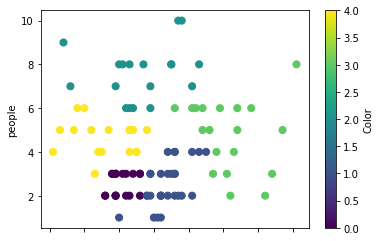

In [24]:
colorsByClusters = {'demo_data__cluster_0':0, 'demo_data__cluster_1': 1, 'demo_data__cluster_2':2,
                    'demo_data__cluster_3':3, 'demo_data__cluster_default':4}

df['Color'] = df['Predicted_Cluster'].apply(lambda x: colorsByClusters.get(x))
df.plot.scatter(x="avgspend", y ="people", c='Color', colormap='viridis', s = 50)

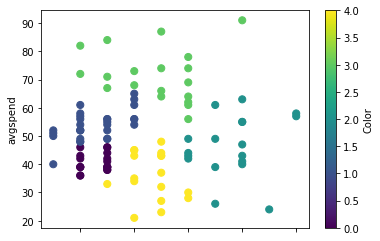

In [25]:
df.plot.scatter(x="people", y ="avgspend", c='Color', colormap='viridis', s = 50)